Avtor: **Luka Knapič**, **23221181**

Datum: 19. december 2023

Potrjujem, da sem avtor projektne naloge in da sem vso vsebino pripravil sam. V primeru, da se ugotovi plagiatorstvo se zavedam, da ne bom izpolnjeval pogojev za pristop k izpitu.


**Navodila za uporabo predloge**


Za uporabo te predloge potrebujemo Python 3.9 ali višje ter naložene nekatere module. Potrebne module naložimo z uporabo sledečih komand.


In [1]:
# !pip install numpy
# !pip install sympy
# !pip install scipy
# !pip install matplotlib
# !pip install pandas
# !pip install importlib
# !pip install ipywidgets

Za polni izkoristek funkcijonalnosti predloge je potrebna povezava z internetom.
<br><br> Naslenje okno poženemo, da v program uvozimo vse potrebne module in skripte:


In [2]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

from src import UI, environment, ball, flight_calculation
from importlib import reload
from IPython.display import display

sym.init_printing()

# Definicija naloge

V nalogi se obravnava dinamika leta golf žogice in prvi odboj po pristanku na zelenici. Dinamika takšnega leta je precej kompleksna zato bomo upoštevali le poglavitne vplive na žogo med letom. Ti vplivi so zračni upor, vzgon kot posledica vrtenja žogice, vpliv vetra ter seveda gravitacije.
<br> <br>Na sliki vidimo vse vplive, ki jih bomo upoštevali v tej nalogi:
<br><br><img src="resources\zoga_vplivi.png\" width=250>


# Matematični uvod

Na žogico v letu deluje veliko različnih faktorjev, v tem projektu bom poskusil zajeti dejavnike z največjim vplivom na let.
<br> Ti dejavniki so:

- Zračni upor
- Magnus efekt
- Veter
- Gravitacija

<br>Odvisni pa so od temperature, tlaka, trenustne hitrosti itd.


Gibalno enačbo lahko začnemo razvijati po 2. Newtonovem zakonu:

<br>$\vec{\ddot{r}}\cdot m_{zogica}  = \vec{F}_{upora}+\vec{F}_{magnus}+\vec{F}_{veter}+\vec{F}_{g} \qquad[1.1]$

<br>Da izrazimo vektor pospeška žoge delimo enačbo z $m_{zogica}$ in dobimo

<br>$\vec{\ddot{r}} = \vec{F}_{upora}/m_{zogice}+\vec{F}_{magnus}/m_{zogice}+\vec{F}_{veter}/m_{zogice}+\vec{g} \qquad[1.2]$

<br>Zdaj pa moramo definirati vsako neznano silo


# Izpeljava sile zračnega upora

<br>Silo zračnega upora modeliramo po kvadratnemu zakonu upora

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\vec{F} = \frac{1}{2}\cdot C_{d}\cdot \rho \cdot A \cdot \vec{v} \odot \vec{v}$

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;kjer $\odot$ označuje operacijo množenja vektorjev po elementih

**poiščimo neznanke:**

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$C_{d}$ je koeficient upora, ki ga bomo spodaj izračunali s pomočjo interpolacije saj ni konstanten, temveč odvisen od hitrosti

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\rho [\frac{Kg}{m^3}]$ bomo izračunali po zakonu idealnih plinov $\rho = \frac{p}{R \cdot T}$, kjer je:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- $p$ tlak [$Pa$]
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- $R$ specifična plinska konstanta [$\frac{J}{Kg \cdot K}$]
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- $T$ temperatura [$K$]

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$A [m^2]$ je projektirana površina, ki se upira zraku izračunana po formuli $A = \pi r^{2}$

<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\vec{v}[m/s]$ pa je spremenljivka


## Interpolacija funkcije koeficienta upora v odvisnosti od Reynoldsovega števila


Izkaže se, da je koeficient trenja $C_{d}$ odvisen od hitrosti potovanja žogice relativno na okoliški zrak. Študija [2] raziskuje ravno to relacijo, v svojih eksperimentih so uporabili odvisnost $C_{d}$ od Reynoldsovega števila. Iz njihovih rezultatov sem tabeliral izmerjene točke za različne proizvajalce golf žogic.
<br>Poglejmo si izmerjene podatke za vse tri žogice


Text(0, 0.5, 'Koeficient upora')

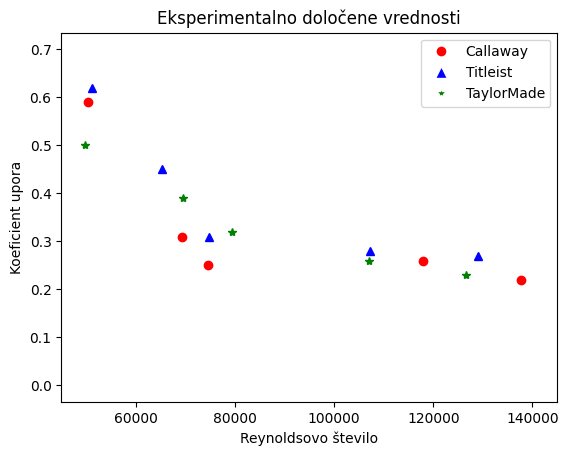

In [3]:
def print_points():
    calloway = ball.read_ball_data(ball_type="Calloway")
    titleist = ball.read_ball_data(ball_type="Titleist")
    taylormade = ball.read_ball_data(ball_type="TaylorMade")


    plt.plot(calloway[:, 0], calloway[:, 1], "ro")
    plt.plot(titleist[:, 0], titleist[:, 1], "b^")
    plt.plot(taylormade[:, 0], taylormade[:, 1], "g*")

print_points()

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="r", markersize=8),
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="b", markersize=8),
    plt.Line2D([0], [0], marker="*", color="w", markerfacecolor="g", markersize=8),
]

legend_labels = ["Callaway", "Titleist", "TaylorMade"]
plt.legend(legend_handles, legend_labels)
plt.title("Eksperimentalno določene vrednosti")
plt.xlim(45000, 145000)
plt.xlabel("Reynoldsovo število")
plt.ylabel("Koeficient upora")

Opazimo, da se upor poveča pri nižjih hitrostih, to nam lahko pri interpolaciji postavi težavo, saj nimamo definiranih točk pri $Re <50000$. Da interpolirano funkcijo približamo realnemu stanju podamo še znano točko $C_d(0) = 0$.
<br><br>Za popis karakteristike potrebujemo funkcijo, da lahko pri poljubnem Renoldsovem številu dobimo koeficient trenja to naredimo z interpolacijo. Interpoliramo z funkcijo `interpolate.InterpolatedUnivariateSpline` iz knjižnice `SciPy`.
<br><br>Ta funkcija z kubičnimi B-zlepki interpolira skozi podane točke in nam vrne sledeče funkcije


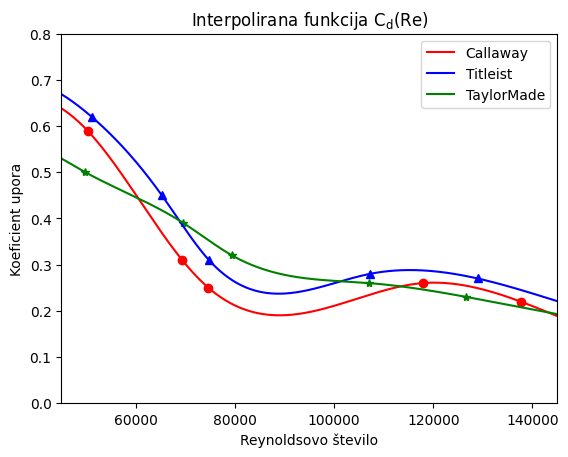

In [4]:
s_ca = ball.c_d_re_interpolation(ball_type="Calloway")
s_ti = ball.c_d_re_interpolation(ball_type="Titleist")
s_ta = ball.c_d_re_interpolation(ball_type="TaylorMade")

test_x = np.linspace(0, 190000, 1000)
test_y_ca = s_ca(test_x)
test_y_ti = s_ti(test_x)
test_y_ta = s_ta(test_x)

plt.title(r"Interpolirana funkcija $\mathregular{C_d}$(Re)")
plt.xlabel("Reynoldsovo število")
plt.ylabel("Koeficient upora")

print_points()

legend_handles = [
    plt.Line2D([0], [0], color="r", markersize=8),
    plt.Line2D([0], [0], color="b", markersize=8),
    plt.Line2D([0], [0], color="g", markersize=8),
]

legend_labels = ["Callaway", "Titleist", "TaylorMade"]

plt.legend(legend_handles, legend_labels)
plt.xlim(45000, 145000)
plt.ylim(0, 0.8)

plt.plot(test_x, test_y_ca, "r")
plt.plot(test_x, test_y_ti, "b")
plt.plot(test_x, test_y_ta, "g")

In tako smo definirali vse neznanke za modeliranje zračnega upora.
<br><br>Končna formula zračnega upora je torej $\vec{F} = \frac{1}{2}\cdot \frac{p}{R \cdot T} \cdot \pi r^{2} \cdot \vec{v} \odot \vec{v} \odot C_{d}(\vec{R_e})$


## Simbolno reševanje $\vec{F}_m$

Sila vzgona zaradi rotacije je povezna z razliko hitrosti z katero fluid obteka telo, to nas pripelje do Bernoullijeve enačbe. Zapišimo jo z izpostevljeno spremembo tlaka
<br><br>$\Delta p=\frac{\rho}{2}(\vec{v_{a}}^{2}-\vec{v_{b}}^{2})$
<br><br>Želimo pa vstaviti vrednosti za $\vec{v_{a}}^{2}$ in $\vec{v_{b}}^{2}$ te dve hitrosti si lahko predstavljamo, kot hitrost z katero zrak obteka žogo na nasprotnih polih. To hitrost lahko zapišemo kot $\vec{v_{a}}=\vec{v_{0}}-\vec{\omega}\times\vec{r}$ in podobno tudi za $\vec{v_{b}}$
<br>Z nadalnjo poenostavitvijo dobimo $\Delta p = \frac{1}{2} \rho r (\vec{\omega}\times \vec{v})$
<br>Vemo, da je $\vec{F} = \int_{A}^{}\Delta p\text{ }dA$ in ko vstavimo vidimo, da je $\vec{F}_m = \frac{1}{2} \rho r (\vec{\omega}\times \vec{v}) \cdot \int_{A}^{}dA = \frac{1}{2} \rho A r (\vec{\omega}\times \vec{v})$.
<br><br> Ker je računanje vektorskega produkta časovno potratno bomo z knjižnico `Sympy` ustvarili numerično funkcijo za hitrejši izračun te sile. Začnimo z definicijo simbolov


In [5]:
rho, r, r_1_s = sym.symbols("rho, r r_1", positive=True)
w = sym.Matrix(sym.MatrixSymbol("w", 3, 1))
v = sym.Matrix(sym.MatrixSymbol("v", 3, 1))

sedaj izračunamo A. A je povprečna projektirana površina žogice. To izračunamo tako, da izenačimo ploščino sredinskega kroga (z radijem $r_1$)
<br>ter ploščino kolobara (z notranjim radijem $r_1$ in zunanjim radijem $r$) in izračunamo $r_1$, ki je radius kroga z povprečno projektirano površino


In [6]:
A_1 = sym.pi * r_1_s**2
A_k = sym.pi * r**2 - A_1
r_1 = sym.solve(sym.Eq(A_1, A_k), r_1_s, positive=True)
r_1[0]

sedaj lahko zapišemo konstantni del enačbe in ga označimo z $S$
<br>$S = \frac{1}{2}\rho \pi r^3$
<br>in to poračunamo z $\vec{\omega}\times \vec{v}$


In [7]:
F = rho * r_1[0] ** 2 * r * sym.pi * w.cross(v)
F

⎡   3                       ⎤
⎢π⋅r ⋅ρ⋅(-v₁₀⋅w₂₀ + v₂₀⋅w₁₀)⎥
⎢───────────────────────────⎥
⎢             2             ⎥
⎢                           ⎥
⎢   3                       ⎥
⎢π⋅r ⋅ρ⋅(v₀₀⋅w₂₀ - v₂₀⋅w₀₀) ⎥
⎢────────────────────────── ⎥
⎢            2              ⎥
⎢                           ⎥
⎢   3                       ⎥
⎢π⋅r ⋅ρ⋅(-v₀₀⋅w₁₀ + v₁₀⋅w₀₀)⎥
⎢───────────────────────────⎥
⎣             2             ⎦

nato pa spremenimo v numerično funkcijo z predvstavljenimi konstantnimi vrednostmi. Vrednosti, ki bodo skozi celoten let konstantne vstavimo pri kreaciji funkcije. Hitrost, ki pa se bo v vsakem časovnem koraku spremenila pa vstavljamo v rezultantno numerično funkcijo in dobimo silo vzgona


In [8]:
F_subs = F.subs({w[0]: 0, w[1]: -200, w[2]: 0, rho: 1.3, r: 0.02})
f = sym.lambdify(v, F_subs, "numpy")
f(50, 0, 15)

array([[-0.04900885],
       [ 0.        ],
       [ 0.16336282]])

# Izpeljava sile vetra

Silo delujočo na žogico med letom bomo izračunali po naslednji formuli
<br><br> $F_{vetra} = 0.5 \cdot \rho \cdot \vec{V}_{vetra} \odot \vec{V}_{vetra} \cdot A$

<br> podatek A imamo izračunan že od prej, $\rho$ izračunamo na podlagi temperature ter tlaka, hitrost vetra pa je podana. Ta enačba je poenostavljena, meddrugim tudi ne upošteva gradienta vetra, sunkov vetra itd.


In [9]:
F_v = 0.5 * 1.3 * 100 * np.pi * 0.02**2
F_v

Tukaj moramo biti pozorni na smer vetra, saj nam $\vec{V}_{vetra} \odot \vec{V}_{vetra}$ predznak izgubi. Ta problem bomo v implementaciji rešili z množenjem z masko predznakov.


# Izračun poti leta


Za izračun leta uporabimo prej izpeljano gibalno enačbo 1.2. Ta enačba nam pove pospešek žoge v odvisnosti od hitrosti žoge, je diferencialna enačba drugega reda.


## Reševanje diferencialne enačbe


Diferencialno enačbo bomo rešili z funkcijo `solve_ivp` iz knjižnice `SciPy`, funkcija se uporablja za reševanje diferencialne enačbe z začentnimi pogoji. Za reševanje ponuja več metod v tej nalogi uporabimo RK45 ali Runge-Kutta četrtega reda. Lokalna napaka te metode je petega reda $\mathcal{O}(h^5)$ globalna pa četrtega reda $\mathcal{O}(h^4)$, napako lahko tako ocenimo po formuli
<br><br>$E_h=\frac{y_{n,h}-y_{n,2h}}{15}$

<br> za izvajanje kalkulacije poti sem namenil skripto `flight_calculation.py`, kjer sem pripravil funkcijo, ki izračuna pospešek pri določeni hitrosti. To funkcijo podamo `solve_ivp`, poleg začetnih pogojev ter seznama časovnih točk, pri katerih želimo oceniti pozicijo žoge. Funkcija `calculate_trajectory` poskrbi za vse te izračune. Opcijsko lahko podamo tudi parametra za čas opazovanja leta `n` in resoulcijo `res`. Kot rezultat pa dobimo seznam hitrosti in pozicije za vsako točko leta v treh dimenzijah


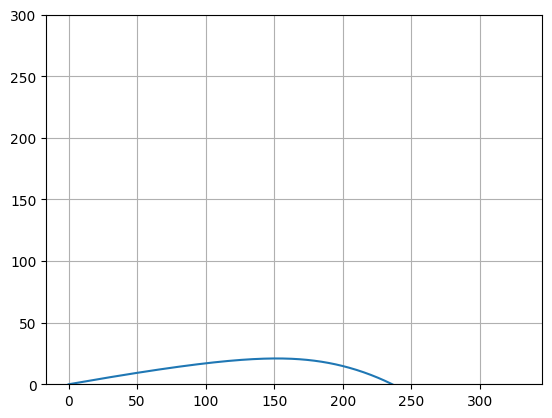

In [10]:
n = 10

flight_data = flight_calculation.calculate_trajectory(n, 50)

plt.plot(flight_data[3], flight_data[5])
plt.grid()
plt.ylim(0, 300)

# Analiza leta
<br>Z funkcijo `analize_flight` dobimo podatke o dolžini udarca, zavoju udarca (slice / draw dolžina), maksimalno doseženo višino, dolžino krivulje leta in čas leta.

## Iskanje ničel


Če želimo vedeti, časovno dolžino leta nas zanima pri kateri časovni točki $z$ koordinata pozicije preseka ničlo. Najprej potrebujemo ustvarit funkcijo pozicije v odvisnosti od časa, kar ponovno opravimo z interpolacijo
<br><br> Ničle numerično poiščemo z `SciPy.optimize.newton`. Uporabljena je sekantna metoda, ker ne podamo odvoda funkcije. Med drugim moramo podati tudi oceno ničle, dana funkcija $z(t)$ ima vrednost nič v dveh točah, kar pomeni, da je izbira začetne predpostavljene vrednosti pomembna iz vidika numerične pravilnosti in ne le časovne optimizacije. Vemo, da se ničla, ki jo iščemo nahaja proti, koncu opazovanega leta, zato je zadnja točka opazovanega leta dovolj dobra ocena.
<br><br> Napaka metode je odvisna od števila iteracij, ocenimo pa jo lahko z razliko med dvema zaporednima približkoma
<br>Funkcija je implementirana v ```flight_calculation.py``` v funkciji ```analize_flight``` 

## Numerično integriranje


Krivuljo izračunamo z integracijo po času od 0 do časa pristanka: $\int_{0}^{t_{d}} \sqrt{v^{2}_{x}(t) + v^{2}_{y}(t) + v^{2}_{z}(t)}dt$.
<br>Numerično pa impementiramo simpsonovo metodo za reševanje integrala, ker integriramo vzorec točk in ne objekta funkcija. Uporabimo `SciPy.integrate.simpson`, funkciji za vsako željeno točko na abscisni osi podamo tudi rezultate funkcije, ki jo želimo integrirati, za vsako od teh točk. Napaka simpsonove metode je definirana kot $E= 
-\frac{b-a}{180}h^4\,f^{(4)}(\eta)$
<br> funkcija je implementirana v `flight_calculation.py` v funkciji ```path_length``` 


Poglejmo si let iz strani ter iz ptičje perspektive, na grafih so dodani podatki iz analize leta


čas leta 5.55s


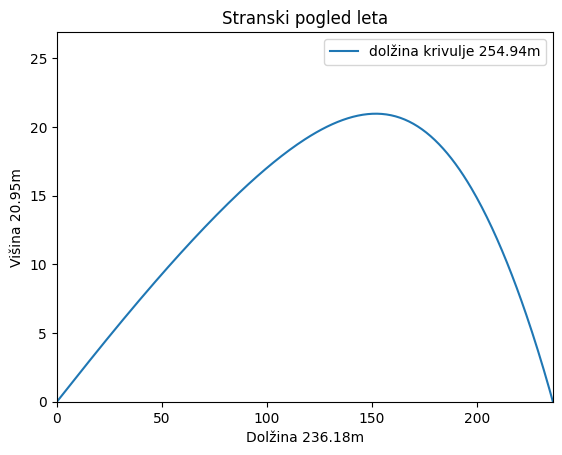

In [11]:
flight_analysis = flight_calculation.analize_flight(flight_data, n)

# x/z
plt.plot(flight_data[3], flight_data[5], label=f"dolžina krivulje {flight_analysis[3]}m")
plt.ylim(0)
plt.xlim(0, flight_analysis[0])
plt.title("Stranski pogled leta")
plt.xlabel(f"Dolžina {flight_analysis[0]}m")
plt.ylabel(f"Višina {flight_analysis[2]}m")
plt.legend()
print(f"čas leta {round(flight_analysis[4], 2)}s")

Text(0, 0.5, 'Zavoj 6.72m')

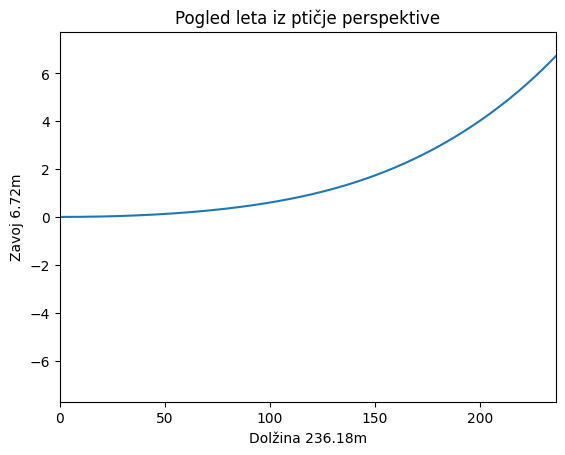

In [12]:
# x/y
plt.plot(flight_data[3], flight_data[4])
plt.ylim(-flight_analysis[1] - 1, flight_analysis[1] + 1)
plt.xlim(0, flight_analysis[0])
plt.title("Pogled leta iz ptičje perspektive")
plt.xlabel(f"Dolžina {flight_analysis[0]}m")
plt.ylabel(f"Zavoj {flight_analysis[1]}m")

# Izračun izgube energije po odboju

Z uporabo podatkov pridobljenih iz raziskave [1] lahko izračunamo hitrost in kotno hitrost žoge po pristanku na zelenico, ki pa so potrebni za preračun energijskih izgub.


## Reševanje sistema linearnih enačb

Podana je $3 x 3$ matrika koeficientov, vektor konstant je sestavljen $[v_x, v_y, w]$ kjer so to parametri pri pristanku. Z uporabo funkcije za reševanje sistema linearnih enačb `numpy.linalg.solve` izračunamo neznanke.
<br><br> Definirajmo koeficiente in vektor konstant


In [13]:
coef_matrix = np.array(
    [
        [0.56771812, 4.53916662, 0.03518492],
        [0.99977526, -4.17652901, -0.02036161],
        [-1.01552552, 5.73823483, 1.15819699],
    ]
)
landing_velocity = np.append(flight_data[0:2, flight_analysis[5]], UI.spin_x_slider.value)

z rešenim sistemom linearnih enačb dobimo podatek o hitrosti in kotni hitrosti po podboju od zelenice. Rezultat pa uporabimo za izračun energijskih izgub


In [14]:
after_landing = np.round(np.linalg.solve(coef_matrix, landing_velocity), 2)

e = 0.3
v_0 = np.linalg.norm(flight_data[:3, flight_analysis[5]])
v_1 = np.linalg.norm(np.append(after_landing[:2], flight_data[2, flight_analysis[5]] * e))
delta_E = round(
    ball.ball_properties.get("mass")
    * (
        0.5 * (v_1**2 - v_0**2)
        + ball.ball_properties.get("diameter")**2
        / 40
        * (after_landing[2] ** 2 - UI.spin_y_slider.value**2)
    ),
    2,
)

print(
    f"sprememba x hitrosti po odboju {round(flight_data[0, flight_analysis[5]] - after_landing[0], 2)} m/s"
)
print(
    f"sprememba y hitrosti po odboju {round(flight_data[1, flight_analysis[5]] - after_landing[1], 2)} m/s"
)
print(
    f"sprememba z hitrosti po odboju {round(flight_data[2, flight_analysis[5]] - flight_data[2, flight_analysis[5]] * e, 2)} m/s"
)
print(
    f"sprememba kotne hitrosti po odboju {round(-UI.spin_y_slider.value + after_landing[2], 2)} rad/s"
)
print(f"sprememba kinetične energije {delta_E} J")

sprememba x hitrosti po odboju 8.84 m/s
sprememba y hitrosti po odboju -1.22 m/s
sprememba z hitrosti po odboju -10.23 m/s
sprememba kotne hitrosti po odboju 197.37 rad/s
sprememba kinetične energije -13.31 J


# Simulacija

Z implementacijo vseh funkcij lahko ustvarimo simulacijo leta za poljubne parametre.

<br><br> V spodnjem uporabniškem vmesniku lahko nastavljamo razne parametre. Izris leta pa se v živo posodablja z spreminjanjem parametrov. Z uporabo večjega monitorja dosežemo boljšo uporabniško izkušnju, v primeru manjšega monitorja pa se pri nastavitvi parametrov pojavi drsnik. Za starejše verzije jupyter notebook-a je za delovanje vmesnika potreben ročni zagon z uporabo komande ```jupyter nbextension enable --py widgetsnbextension``` v terminalu.
<br><br> **Žoga:**
<br>lahko vzamemo pripravljene podatke za vsako palico ali pa izklopimo ```Uporabi Pre-set parametre```, pokaže se nam več opcij, ki vplivajo na let žoge.
<br>Imamo tudi možnost izbirati tip žoge, ki, kot smo prej videli, spremeni vpliv upora zraka.
<br><br> **Vreme**
<br>Vreme lahko nastavimo ročno ali pa obkljukamo ```Uporabi lokalno vreme```, ki pokliče trenutne podatke v izbranem mestu. Za uporabo funkcije je potrebna internetna povezava.
<br><br>Za ponastavitev parametrov ponovno poženite spodnjo celico

In [15]:
reload(UI)
reload(flight_calculation)
reload(environment)
reload(ball)
UI.live_plot()

# Literatura

[1]
S. W. Biber, K. M. Jones, A. R. Champneys, R. Green, and R. Szalai, “Measurements and linearized models for golf ball bounce on a green,” Sports Engineering, vol. 26, no. 1, Dec. 2023, doi: https://doi.org/10.1007/s12283-023-00442-4.

[2]
F. Alam et al., “A study of golf ball aerodynamic drag,” Procedia Engineering, vol. 13, pp. 226–231, 2011, doi: https://doi.org/10.1016/j.proeng.2011.05.077.

‌

‌